<a href="https://colab.research.google.com/github/veronikaandruschenko/INF6018_Final_Project_Andrushchenko/blob/main/project_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

# 1. Load all three files
df_nac = pd.read_excel("delfi_nacionaliniai.xlsx")
df_pag = pd.read_excel("delfi_pagrindinis.xlsx")
df_val = pd.read_excel("delfi_valstybiniai.xlsx")


# 2. Rename columns to match structure (URL column differs in each file)
df_nac = df_nac.rename(columns={
    "title": "title",
    "date": "date",
    "text": "text",
    "data-page-selector": "url"   # national exam: URL column
})

df_pag = df_pag.rename(columns={
    "title": "title",
    "date": "date",
    "text": "text",
    "data-page-selector": "url"   # pagrindinis exam: URL column
})

df_val = df_val.rename(columns={
    "title": "title",
    "date": "date",
    "text": "text",
    "data-page-selector": "url"   # valstybiniai exam: URL column
})


# 3. Keep only necessary columns
cols = ["title", "date", "text", "url"]

df_nac = df_nac[cols]
df_pag = df_pag[cols]
df_val = df_val[cols]

# 4. Merge all files
df = pd.concat([df_nac, df_pag, df_val], ignore_index=True)

print("Rows before removing duplicates:", len(df))

# 5. Remove duplicates by URL
df = df.drop_duplicates(subset=["url"])
print("Rows after removing duplicates:", len(df))

# 6. Clean and filter dates (2020–2025)
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])

df["year"] = df["date"].dt.year
df = df[df["year"].between(2020, 2025)]

print("Rows after filtering 2020–2025:", len(df))

# 7. Save final merged file
df.to_csv("merged_final.csv", sep=";", index=False, encoding="utf-8")


Rows before removing duplicates: 272
Rows after removing duplicates: 249
Rows after filtering 2020–2025: 204


In [3]:
!pip install vaderSentiment

import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

plt.rcParams["figure.figsize"] = (6,4)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.3 MB/s eta 0:00:00


In [4]:
# Load pre-cleaned merged dataset
df = pd.read_csv("merged_final.csv", sep=";")

print("Number of articles:", len(df))
print(df.head(3)[["title", "date", "url"]])

# Parse dates again
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])
df["year"] = df["date"].dt.year

print("Years in dataset:", sorted(df["year"].unique()))
print("Final number of rows:", len(df))


Number of articles: 204
                                               title                 date  \
0  Prasidėjus karantinui iškilo klausimas dėl abi...  2020-04-07 12:32:00   
1  Mokinių pasiekimų reitingai: prestižinių gimna...  2020-05-06 11:01:00   
2  Lietuva jau dabar ruošiasi blogiausiam scenari...  2020-09-07 14:10:00   

                                                 url  
0  https://www.delfi.lt/projektai/studijos/prasid...  
1  https://www.delfi.lt/news/daily/lithuania/moki...  
2  https://www.delfi.lt/news/daily/education/liet...  
Years in dataset: [np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024), np.int32(2025)]
Final number of rows: 204


In [5]:
sia = SentimentIntensityAnalyzer()

# Apply VADER scores to the article text
scores = df["text"].astype(str).apply(sia.polarity_scores)

df["neg"] = scores.apply(lambda x: x["neg"])
df["neu"] = scores.apply(lambda x: x["neu"])
df["pos"] = scores.apply(lambda x: x["pos"])
df["compound"] = scores.apply(lambda x: x["compound"])

def vader_label(c):
    if c >= 0.05:
        return "positive"
    elif c <= -0.05:
        return "negative"
    else:
        return "neutral"

df["sentiment"] = df["compound"].apply(vader_label)

print("Sentiment label distribution:")
print(df["sentiment"].value_counts())
print("\nSentiment label percentages (%):")
print((df["sentiment"].value_counts(normalize=True) * 100).round(2))

# Save dataset with sentiment columns
df.to_csv("merged_with_sentiment.csv", sep=";", index=False)
print("\nSaved: merged_with_sentiment.csv")


Sentiment label distribution:
sentiment
neutral     131
negative     69
positive      4
Name: count, dtype: int64

Sentiment label percentages (%):
sentiment
neutral     64.22
negative    33.82
positive     1.96
Name: proportion, dtype: float64

Saved: merged_with_sentiment.csv


Rows: 204
Years: [np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024), np.int32(2025)]
                                               title                date  \
0  Prasidėjus karantinui iškilo klausimas dėl abi... 2020-04-07 12:32:00   
1  Mokinių pasiekimų reitingai: prestižinių gimna... 2020-05-06 11:01:00   
2  Lietuva jau dabar ruošiasi blogiausiam scenari... 2020-09-07 14:10:00   

  sentiment  
0  negative  
1  positive  
2   neutral  


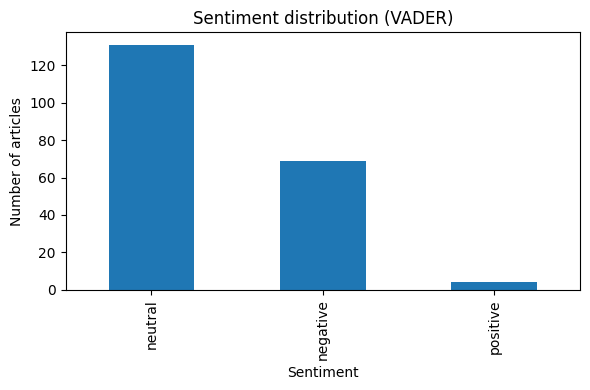

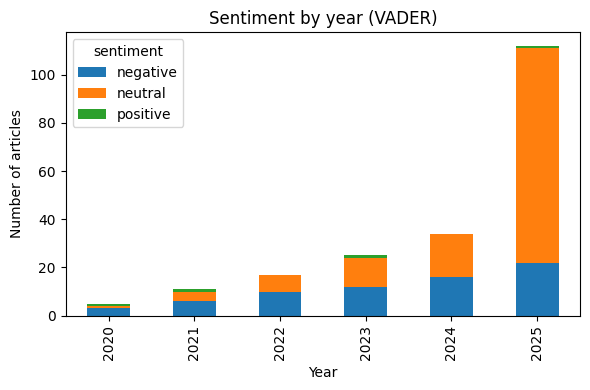

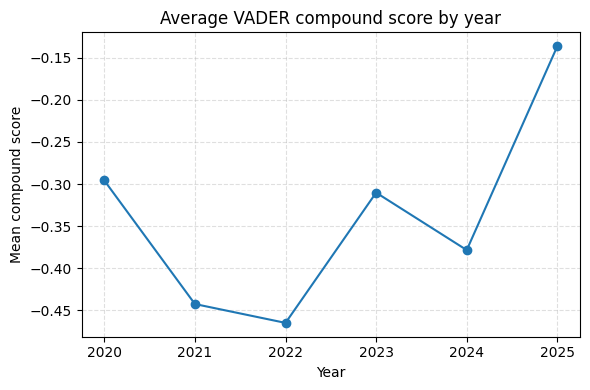

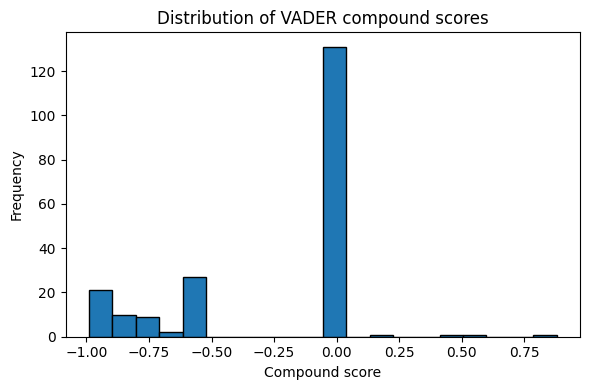

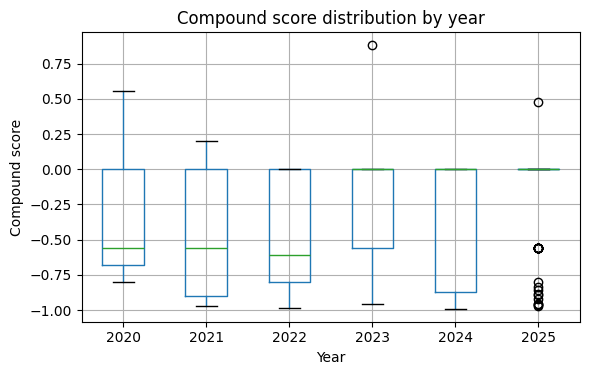

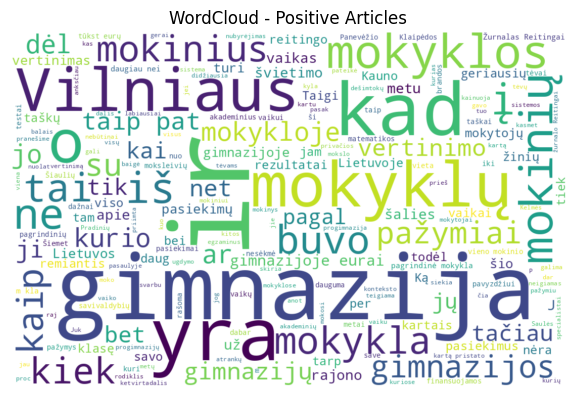

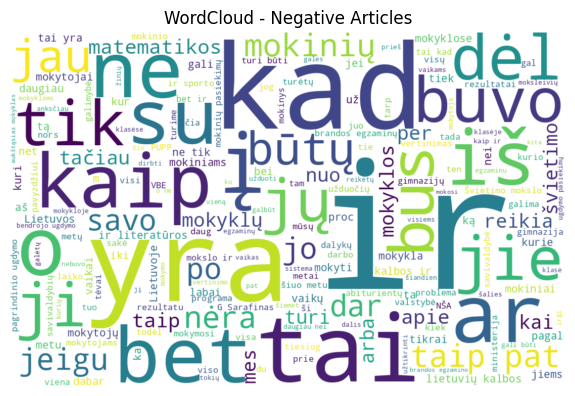


Top 10 positive articles:


,date,title,compound,sentiment
29,2023-01-19 20:30:00,"Specialistė pasakė, ko stokoja vien dešimtukai...",0.8796,positive
1,2020-05-06 11:01:00,Mokinių pasiekimų reitingai: prestižinių gimna...,0.5574,positive
184,2025-07-24 15:00:00,NaN,0.4767,positive
10,2021-05-12 11:47:00,"Gimnazijų reitingas atsakė į klausimą, ar moky...",0.2023,positive
8,2021-05-03 12:17:00,Prasideda 4 ir 8 klasių mokinių matematikos ir...,0.0000,neutral
11,2021-10-09 18:47:00,Privačiam universitetui pamatus klojęs Chmieli...,0.0000,neutral
30,2023-01-23 09:45:00,Lietuvos mokyklose prasideda Nacionalinis moki...,0.0000,neutral
25,2022-12-22 11:38:00,"Nuspręsta: mokinių patikrinimai bus privalomi,...",0.0000,neutral
17,2022-05-12 06:01:00,Tyrimo rezultatai keičia darbo rinkos žaidimo ...,0.0000,neutral
23,2022-12-04 22:43:00,Jurgita Šiugždinienė. Vaikus rengiame gyvenimu...,0.0000,neutral



Top 10 negative articles:


,date,title,compound,sentiment
111,2024-10-12 22:00:00,Atviras išskirtinio šalies mokytojo interviu –...,-0.9898,negative
47,2024-03-29 16:25:00,Gediminas Merkys. Brandos egzaminų ir tarpinių...,-0.9860,negative
27,2022-12-30 09:29:00,Svarbiausi 2022 metų Lietuvos įvykiai,-0.9831,negative
102,2024-07-12 16:49:00,Vigilijus Jukna. Švietimo reformomis kelias į ...,-0.9762,negative
12,2021-11-03 11:17:00,Mokinių laukia gausybė pokyčių: planuoja keist...,-0.9705,negative
72,2025-06-11 13:03:00,Prabilo apie pakeitimus mokyklose – pokyčiai p...,-0.9705,negative
75,2022-11-29 07:57:00,Urbanovič apie PUPP egzaminų pakeitimus: nukre...,-0.9636,negative
129,2025-10-15 12:37:00,Politologas: švietimo ministrė turėtų atsistat...,-0.9630,negative
88,2023-08-24 10:56:00,Švietimo ministerija išvardijo šių mokslo metų...,-0.9584,negative
73,2025-07-01 14:50:00,"NŠA vadovas apie ištesėtus pažadus, pasikeitus...",-0.9584,negative


In [6]:
# Install wordcloud once if needed
!pip install wordcloud

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

plt.rcParams["figure.figsize"] = (6,4)

# 1. Load data
df = pd.read_csv("merged_with_sentiment.csv", sep=";")

# Restore date and year
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])
df["year"] = df["date"].dt.year

print("Rows:", len(df))
print("Years:", sorted(df["year"].unique()))
print(df[["title", "date", "sentiment"]].head(3))


# 2. Overall sentiment distribution
df["sentiment"].value_counts().plot(kind="bar")
plt.title("Sentiment distribution (VADER)")
plt.xlabel("Sentiment")
plt.ylabel("Number of articles")
plt.tight_layout()
plt.show()

# 3. Sentiment by year (stacked bar)
yearly_counts = (
    df.groupby(["year", "sentiment"])
      .size()
      .unstack(fill_value=0)
)

yearly_counts.plot(kind="bar", stacked=True)
plt.title("Sentiment by year (VADER)")
plt.xlabel("Year")
plt.ylabel("Number of articles")
plt.tight_layout()
plt.show()

# 4. Average compound score per year
avg_comp = df.groupby("year")["compound"].mean()

avg_comp.plot(marker="o")
plt.title("Average VADER compound score by year")
plt.xlabel("Year")
plt.ylabel("Mean compound score")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# 5. Histogram of compound scores
df["compound"].plot(kind="hist", bins=20, edgecolor="black")
plt.title("Distribution of VADER compound scores")
plt.xlabel("Compound score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 6. Boxplot of compound by year
df.boxplot(column="compound", by="year")
plt.title("Compound score distribution by year")
plt.suptitle("")  # remove automatic title
plt.xlabel("Year")
plt.ylabel("Compound score")
plt.tight_layout()
plt.show()


# 7. WordClouds for positive & negative=
stopwords = set(STOPWORDS)

# Positive articles
pos_text = " ".join(df[df["sentiment"]=="positive"]["text"].astype(str))
if len(pos_text.strip()) > 0:
    wc_pos = WordCloud(width=1100, height=700,
                       background_color="white",
                       stopwords=stopwords).generate(pos_text)
    plt.imshow(wc_pos, interpolation="bilinear")
    plt.axis("off")
    plt.title("WordCloud - Positive Articles")
    plt.tight_layout()
    plt.show()
else:
    print("No positive texts for wordcloud.")

# Negative articles
neg_text = " ".join(df[df["sentiment"]=="negative"]["text"].astype(str))
if len(neg_text.strip()) > 0:
    wc_neg = WordCloud(width=1100, height=700,
                       background_color="white",
                       stopwords=stopwords).generate(neg_text)
    plt.imshow(wc_neg, interpolation="bilinear")
    plt.axis("off")
    plt.title("WordCloud - Negative Articles")
    plt.tight_layout()
    plt.show()
else:
    print("No negative texts for wordcloud.")


# 8. Top 10 most positive / negative
top_pos = df.sort_values("compound", ascending=False).head(10)
top_neg = df.sort_values("compound", ascending=True).head(10)

print("\nTop 10 positive articles:")
display(top_pos[["date", "title", "compound", "sentiment"]])

print("\nTop 10 negative articles:")
display(top_neg[["date", "title", "compound", "sentiment"]])


In [ ]:
df.groupby(["year", "sentiment"]).size()


year  sentiment
2020  negative      3
      neutral       1
      positive      1
2021  negative      6
      neutral       4
      positive      1
2022  negative     10
      neutral       7
2023  negative     12
      neutral      12
      positive      1
2024  negative     16
      neutral      18
2025  negative     22
      neutral      89
      positive      1
dtype: int64

In [ ]:
import pandas as pd

# Top 10 positive
top_pos = (
    df.sort_values("compound", ascending=False)
      .head(10)[["date", "title", "url", "compound", "sentiment"]]
)
top_pos.insert(0, "group", "Positive")

# Top 10 negative
top_neg = (
    df.sort_values("compound", ascending=True)
      .head(10)[["date", "title", "url", "compound", "sentiment"]]
)
top_neg.insert(0, "group", "Negative")

# Combine into one table
table1 = pd.concat([top_pos, top_neg], ignore_index=True)

# Save as Excel
table1.to_excel("table1_top10_positive_negative.xlsx", index=False)


Saved as table1_top10_positive_negative.xlsx
